# HRD Feature Engineering | Canonical HRD Scores (TAI+LST+LOH)

**Objective**: Integrate externally derived genomic scar–based HRD composite scores with DepMap cell lines to enable downstream analyses of PARP inhibitor sensitivity.

---
---
---

## 1. Setup 📦

---
---

In [1]:
# Data Management
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import ptitprince as pt
import seaborn as sns

# Computational Modules
from scipy.stats import norm, spearmanr, zscore
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Utils
from IPython.display import display, HTML, IFrame, Image
from pathlib import Path

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)
sns.set_style('darkgrid', {'grid.color':'0.9','xtick.bottom':True,'ytick.left':True})

## 2. Data Loading ⚙️

**Objective**: Load and organize DepMap cell line data and external HRD-related feature sets.

---
---

In [2]:
# Define project root and file path relative to user OS
BASE_DIR = Path.cwd()
CCL_PARPI_PATH              = BASE_DIR / 'utils' / 'ccl_parpi_df.pkl'
CELL_LINE_MODELS_PATH       = BASE_DIR / 'data' / 'Models.csv'
CRC_HRD_SCORES_PATH         = BASE_DIR / 'data' / 'crc_hrd_scores.csv'

In [3]:
# Load data into local dataframes (with disabled chunked dtype inference)
ccl_parpi_df                = pd.read_pickle(CCL_PARPI_PATH)
ccl_models_df               = pd.read_csv(CELL_LINE_MODELS_PATH, low_memory=False)
crc_hrd_df                  = pd.read_csv(CRC_HRD_SCORES_PATH, low_memory=False)

The original cell line data was downloaded from DepMap’s public [portal](https://depmap.org/portal/data_page/?tab=allData). HRD sum values were obtained from a [research-compiled source](https://pmc.ncbi.nlm.nih.gov/articles/PMC11621922/#_ad93_).

- **`ccl_models_df`**: Contains metadata describing all cancer cell line models from the DepMap portal. 

- **`crc_hrd_df`**: Contains HRD sum values across cancer cell line models from multiple sources.

**NOTE:** Cell line metadata were obtained from DepMap release 25Q3. PRISM secondary drug response data was obtained from earlier DepMap release (20Q2), as some datasets are not updated every quarter. All datasets are harmonized using stable DepMap ModelIDs. 

This project aims to systematically examine how multiple definitions of HRD relate to drug response across all PARP inhibitors available in the dataset. So each of the HRD feature engineering notebooks will derive homologous recombination deficiency (HRD) status using one of three complementary strategies: (1) BRCA1/2 double-hit alteration status, (2) composite HRD scores, and (3) COSMIC mutational signatures. These engineered features will then be harmonized with PARP inhibitor AUC measurements to generate a modeling-ready dataset for downstream statistical analysis and predictive modeling of HRD-associated drug response. This notebook will focus on composite HRD scores, extracted from sources external to the DepMap CCL database.

## 3. Composite HRD Scores [HRD Component 2 | Version 2] 🧮

**Objective**: Validate and merge external HRD scores with DepMap cell lines.

**Methodology**: First, the external set is inspected to identify the primary merge key, as well as, potential alternative IDs. Second, the DepMap cell line undergo a basic validation process to prepare for the merge. Third, the alternative IDs for missing DepMap IDs in the external set is reviewed for potential recovery during the merge. Fourth, the merge is conducted, retaining as many external HRD records as possible. Lastly, the merged data undergoes cursory explorations and preprocessing to construct a HRD score-based label for use in future notebooks.

---
---

Homologous recombination deficiency (HRD) can be quantified using genomic scar–based metrics that capture structural consequences of impaired DNA repair. One widely used approach is the **HRD sum score**, a composite metric derived from three independent measures of chromosomal instability:

- **Loss of Heterozygosity (LOH)** <br/>Refers to regions of the genome where one parental allele has been lost without a corresponding change in total copy number. In HR-deficient cells, improper repair of DNA breaks can lead to segmental deletions or unbalanced repair events, resulting in extended stretches of allelic loss. A high LOH reflects defective homologous recombination and reliance on error-prone repair pathways.
  
- **Telomeric Allelic Imbalance (TAI)** <br/>Represents regions of allelic imbalance that extend to the telomere but do not cross the centromere. These arise when DNA repair errors produce unequal chromosomal segments that persist to chromosome ends. Elevated TAI indicates improper resolution of replication-associated DNA damage and is a hallmark of HR dysfunction.
  
- **Large-Scale State Transitions (LST)** <br/>Capture chromosomal breakpoints between adjacent regions of at least several megabases in size. A high LST count reflects large chromosomal rearrangements caused by faulty repair of double-strand breaks, indicative of genome-wide structural instability.

The HRD sum score aggregates these three components to quantify cumulative genomic scarring. Higher scores reflect greater chromosomal instability consistent with impaired homologous recombination repair and are also frequently associated with BRCA1/2 dysfunction and enhanced sensitivity to PARP inhibition.

In this notebook, externally derived HRD sum values are integrated with curated DepMap cell line data to evaluate how genomic scar–based HRD relates to PARP inhibitor response across clinically relevant cancer models.

[Source](https://resources.qiagenbioinformatics.com/manuals/biomedicalgenomicsanalysis/2402/index.php?manual=Calculate_HRD_Score_beta.html)

### 3a. Inspect external HRD sum data for merge.

---

In [4]:
crc_hrd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cell_line                1414 non-null   object 
 1   DepMap_ID                1407 non-null   object 
 2   Sanger_ID                1411 non-null   object 
 3   tissue                   1414 non-null   object 
 4   hrdsum_broad             997 non-null    float64
 5   hrdsum_sanger_sangerwes  1047 non-null   float64
 6   hrdsum_sanger_broadwes   324 non-null    float64
 7   hrdsum_summary           1414 non-null   int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 88.5+ KB


There are 1,414 records in this external HRD dataset, indicating partial but substantial coverage of DepMap cancer cell lines (2,132 total models). Seven entries lack a corresponding `DepMap_ID` and will require reconciliation using `Sanger_ID` during the merge process to maximize alignment.

Four HRD sum variables are provided, reflecting differences in sequencing platform and analytical pipeline:
- `hrdsum_broad`: HRD sum derived from Broad Institute sequencing and copy number profiling.
- `hrdsum_sanger_sangerwes`: HRD sum computed using Sanger sequencing data processed through the Sanger whole-exome pipeline.
- `hrdsum_sanger_broadwes`: HRD sum derived from Sanger sequencing data processed through the Broad whole-exome pipeline.
- `hrdsum_summary`: Harmonized or consensus HRD sum value integrating available platform-specific estimates.

To ensure consistency and minimize platform-specific variability, `hrdsum_summary` will serve as the primary composite HRD metric for downstream analyses. However, all four HRD sum variables will be retained during initial integration to preserve flexibility for sensitivity analyses and potential cross-platform comparisons. Final feature selection and pruning will be performed in subsequent harmonization notebooks.

### 3b. Prepare DepMap cell line data for merge.

---

The full DepMap cell line metadata will be used as the reference set for HRD score integration to ensure comprehensive coverage across all available cancer models, rather than restricting to the curated set. This is to maintain flexibility for future analyses beyond the current project scope. 

A subsequent notebook will integrate the curated PARPi cohort with all the engineered HRD features later, at which point this HRD sum data will be aligned with the drug-response subset in a unified and methodologically consistent manner.

In [5]:
# Retain only metadata columns relevant for downstream analysis
columns_of_interest = [
    # Identifiers
    'ModelID',
    'SangerModelID',
    
    # Lineage Annotation
    'OncotreeLineage',
    'OncotreePrimaryDisease',
    'OncotreeSubtype',
    
    # Patient Context
    'Age',
    'AgeCategory',
    'Sex',
    'PatientRace',
    
    # Bio Context
    'PrimaryOrMetastasis',
    'GrowthPattern',
]

# Subset dataframe
ccl_models_df = (
    ccl_models_df[columns_of_interest]
    .copy()
)

In [6]:
# Check for any duplicate ccl records
print(ccl_models_df.duplicated().sum())

# Check for missing DepMap IDs
print(ccl_models_df.ModelID.isna().sum())

0
0


In [7]:
ccl_models_df

,ModelID,SangerModelID,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,Age,AgeCategory,Sex,PatientRace,PrimaryOrMetastasis,GrowthPattern
0,ACH-000001,SIDM00105,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,60.0,Adult,Female,caucasian,Metastatic,Adherent
1,ACH-000002,SIDM00829,Myeloid,Acute Myeloid Leukemia,AML with Myelodysplasia-Related Changes,36.0,Adult,Female,caucasian,Primary,Suspension
2,ACH-000003,SIDM00891,Bowel,Colorectal Adenocarcinoma,Colon Adenocarcinoma,72.0,Adult,Male,caucasian,Primary,Adherent
3,ACH-000004,SIDM00594,Myeloid,Acute Myeloid Leukemia,"AML, NOS",30.0,Adult,Male,caucasian,Primary,Suspension
4,ACH-000005,SIDM00593,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,30.0,Adult,Male,caucasian,NaN,Mixed
...,...,...,...,...,...,...,...,...,...,...,...
2127,ACH-003473,NaN,Soft Tissue,Rhabdomyosarcoma,Embryonal Rhabdomyosarcoma,1.0,Pediatric,Female,caucasian,Primary,Adherent
2128,ACH-003474,NaN,Head and Neck,Head and Neck Squamous Cell Carcinoma,Head and Neck Squamous Cell Carcinoma,77.0,Adult,Male,caucasian,Primary,Adherent
2129,ACH-003475,NaN,Head and Neck,Head and Neck Squamous Cell Carcinoma,Head and Neck Squamous Cell Carcinoma,76.0,Adult,Female,caucasian,Metastatic,Adherent
2130,ACH-003476,NaN,Esophagus/Stomach,Esophageal Squamous Cell Carcinoma,Esophageal Squamous Cell Carcinoma,76.0,Adult,Female,caucasian,Primary,Adherent


Initial integrity checks confirm that there are no duplicate records and no missing `ModelID` values, ensuring a stable and unique key for merging external HRD score data. Other identification attributes (i.e., `SangerModelID`) were also retained due to missing DepMap IDs in the external set.

### 3c. Merge HRD sums with DepMap cell lines.

---

In [8]:
### Separate HRD dataset based on DepMap_ID availability

# Records WITH DepMap_ID (primary merge set)
crc_hrd_depID = crc_hrd_df[
    crc_hrd_df['DepMap_ID'].notna()
].reset_index(drop=True)

# Records WITHOUT DepMap_ID (require Sanger_ID fallback)
crc_hrd_sangerID = crc_hrd_df[
    crc_hrd_df['DepMap_ID'].isna()
].reset_index(drop=True)

# Ensure separation occured as expected
print('Total HRD records:', len(crc_hrd_df))
print('With DepMap_ID:', len(crc_hrd_depID))
print('Without DepMap_ID:', len(crc_hrd_sangerID))

Total HRD records: 1414
With DepMap_ID: 1407
Without DepMap_ID: 7


In [9]:
# Check if 7 Sanger IDs exist within DepMap data
alt_ids = crc_hrd_sangerID['Sanger_ID'].values.tolist()

# Cross check available Sanger IDs with DepMap version
depmap_sanger_ids = [id for id in alt_ids if id in ccl_models_df['SangerModelID']]

# Examine if alternative ID-based merge is useful
print('Number of matching Sanger IDs: ', len(depmap_sanger_ids))
print('Matching IDs: ', depmap_sanger_ids)

Number of matching Sanger IDs:  0
Matching IDs:  []


In [10]:
# Merge on DepMap_ID
ccl_hrd_sums_df = ccl_models_df.merge(
    crc_hrd_depID,
    left_on='ModelID',
    right_on='DepMap_ID',
    how='left'
)

# Drop redundant merge keys and keep features of interest
ccl_hrd_sums_df = ccl_hrd_sums_df.drop(
    columns=['DepMap_ID', 'SangerModelID', 'cell_line', 'Sanger_ID', 'tissue'],
)

ccl_hrd_sums_df

,ModelID,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,Age,AgeCategory,Sex,PatientRace,PrimaryOrMetastasis,GrowthPattern,hrdsum_broad,hrdsum_sanger_sangerwes,hrdsum_sanger_broadwes,hrdsum_summary
0,ACH-000001,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,60.0,Adult,Female,caucasian,Metastatic,Adherent,35.0,34.0,NaN,32.0
1,ACH-000002,Myeloid,Acute Myeloid Leukemia,AML with Myelodysplasia-Related Changes,36.0,Adult,Female,caucasian,Primary,Suspension,14.0,14.0,NaN,12.0
2,ACH-000003,Bowel,Colorectal Adenocarcinoma,Colon Adenocarcinoma,72.0,Adult,Male,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN
3,ACH-000004,Myeloid,Acute Myeloid Leukemia,"AML, NOS",30.0,Adult,Male,caucasian,Primary,Suspension,29.0,23.0,NaN,24.0
4,ACH-000005,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,30.0,Adult,Male,caucasian,NaN,Mixed,32.0,NaN,NaN,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,ACH-003473,Soft Tissue,Rhabdomyosarcoma,Embryonal Rhabdomyosarcoma,1.0,Pediatric,Female,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN
2128,ACH-003474,Head and Neck,Head and Neck Squamous Cell Carcinoma,Head and Neck Squamous Cell Carcinoma,77.0,Adult,Male,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN
2129,ACH-003475,Head and Neck,Head and Neck Squamous Cell Carcinoma,Head and Neck Squamous Cell Carcinoma,76.0,Adult,Female,caucasian,Metastatic,Adherent,NaN,NaN,NaN,NaN
2130,ACH-003476,Esophagus/Stomach,Esophageal Squamous Cell Carcinoma,Esophageal Squamous Cell Carcinoma,76.0,Adult,Female,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN


The external HRD dataset was first partitioned based on `DepMap_ID` availability. 1407/1414 records contained a valid `DepMap_ID` and were designated as the primary merge set. The remaining 7 records lacked a `DepMap_ID` and were evaluated for potential recovery using `Sanger_ID` as an alternative key. However, a cross-check confirmed that none of the 7 `Sanger_ID` values were present in the current DepMap release. To that extent, HRD scores were merged exclusively using the depmap IDs via a left join, preserving all the HRD score-related features. 

### 3d. Perform cursory explorations to determine labeling strategies.

---

In [11]:
# Examine missing records within HRD sums 
ccl_hrd_sums_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ModelID                  2132 non-null   object 
 1   OncotreeLineage          2119 non-null   object 
 2   OncotreePrimaryDisease   2132 non-null   object 
 3   OncotreeSubtype          2132 non-null   object 
 4   Age                      1704 non-null   float64
 5   AgeCategory              2132 non-null   object 
 6   Sex                      2109 non-null   object 
 7   PatientRace              682 non-null    object 
 8   PrimaryOrMetastasis      1786 non-null   object 
 9   GrowthPattern            2132 non-null   object 
 10  hrdsum_broad             995 non-null    float64
 11  hrdsum_sanger_sangerwes  1036 non-null   float64
 12  hrdsum_sanger_broadwes   323 non-null    float64
 13  hrdsum_summary           1401 non-null   float64
dtypes: float64(5), object(9)

Out of the 1407 available records for the merge, almost all of them retain a `hrdsum_summary` value.

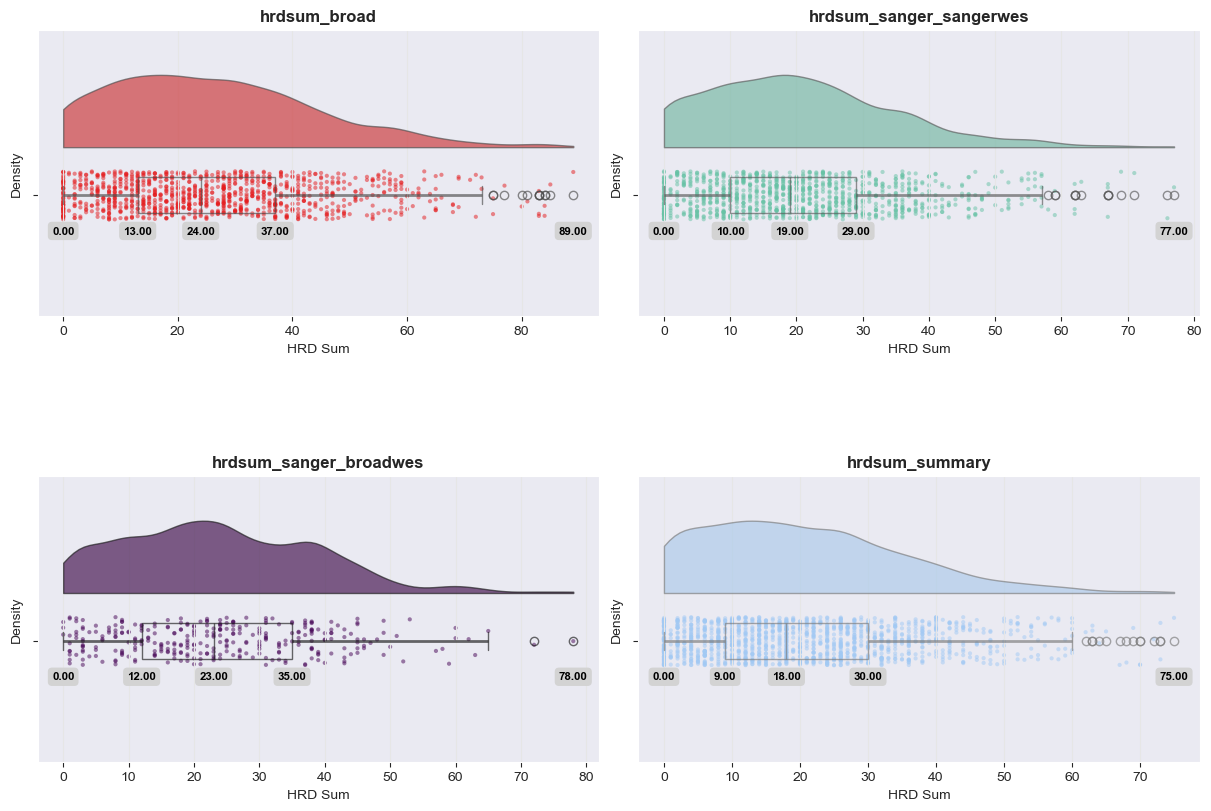

In [12]:
# HRD sum metrics
scar_metrics = ['hrdsum_broad', 'hrdsum_sanger_sangerwes', 'hrdsum_sanger_broadwes', 'hrdsum_summary']

# Set up figure & individual subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), 
    layout='constrained', gridspec_kw={'hspace': 0.25})
axs = axs.flatten()  # for easy indexing
rc_palettes = ['Set1', 'Set2', 'viridis', 'pastel']

# Plot raincloud for each metric
for i, metric in enumerate(scar_metrics):
    cloud = pt.RainCloud(
        data=ccl_hrd_sums_df,
        y=metric,
        bw=0.2,
        alpha=0.65,
        rain_alpha=0.5,
        width_viol=0.6,
        orient='h',
        palette=rc_palettes[i],
        hue=i,
        ax=axs[i],
    )
    
    # Label quartiles
    desc_stats = ccl_hrd_sums_df[[metric]].quantile(q=[0, 0.25, 0.5, 0.75, 1])
    for stat in desc_stats[metric]:
        cloud.text(
            s=f"{stat:.2f}",
            x=stat,
            y=0.16,
            ha='center',
            size='small',
            color='black',
            weight='semibold',
            bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
        )
        
    # Set titles and labels
    axs[i].set_title(f'{metric}', fontsize=12, weight='semibold')
    axs[i].set_xlabel('HRD Sum', fontsize=10)
    axs[i].set_ylabel('Density', fontsize=10)

plt.show()

The HRD sum scores look broadly similar across the Broad, Sanger, and combined datasets. Most cell lines fall in the low-to-mid range, with a smaller group showing clearly higher HRD values. There are some differences in spread and in how long the upper tail extends, likely due to platform or processing differences, but the overall pattern is consistent. In particular, the presence of a distinct high-HRD subset across datasets suggests the signal is biologically meaningful rather than purely technical.

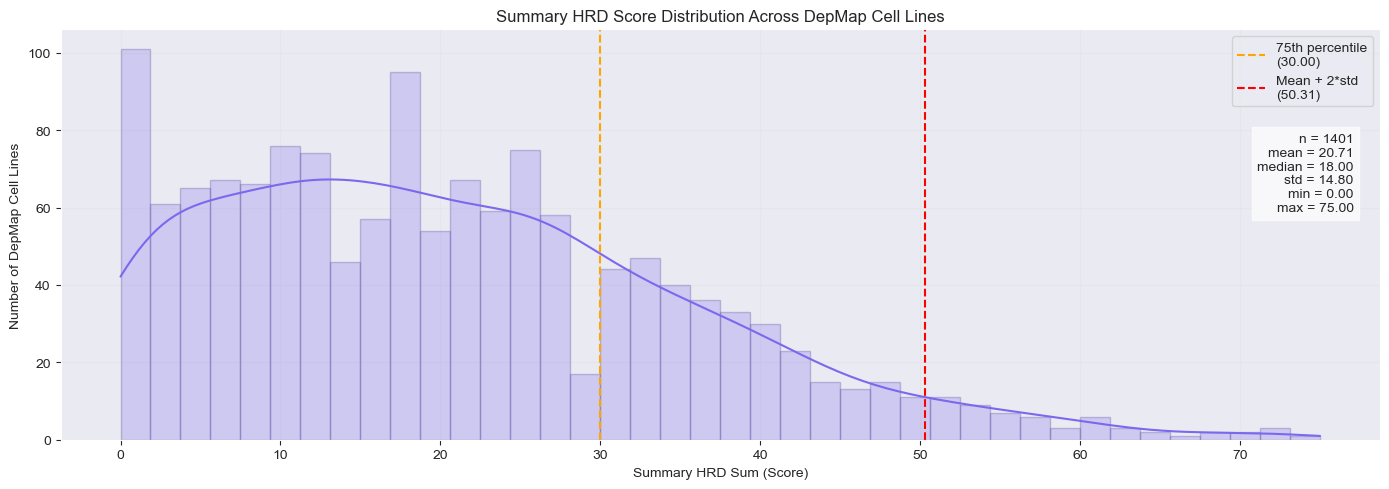

In [13]:
# Compute candidate thresholds
percentile_75_thresh = ccl_hrd_sums_df['hrdsum_summary'].quantile(0.75)
std_based_thresh    = ccl_hrd_sums_df['hrdsum_summary'].mean() + 2 * ccl_hrd_sums_df['hrdsum_summary'].std()

# Set up figure
plt.figure(figsize=(14, 5))

# Histogram + KDE
sns.histplot(
    ccl_hrd_sums_df['hrdsum_summary'], 
    bins=40, 
    kde=True, 
    color='mediumslateblue', 
    alpha=0.25, 
    edgecolor=(0.3, 0.3, 0.6, 0.3)
)

# Add thresholds
plt.axvline(percentile_75_thresh, color='orange', linestyle='--', 
            label=f'75th percentile\n({percentile_75_thresh:.2f})')
plt.axvline(std_based_thresh, color='red', linestyle='--', 
            label=f'Mean + 2*std\n({std_based_thresh:.2f})')

# Summary stats
summary_text = (f"n = {ccl_hrd_sums_df['hrdsum_summary'].count()}\n"
                f"mean = {ccl_hrd_sums_df['hrdsum_summary'].mean():.2f}\n"
                f"median = {ccl_hrd_sums_df['hrdsum_summary'].median():.2f}\n"
                f"std = {ccl_hrd_sums_df['hrdsum_summary'].std():.2f}\n"
                f"min = {ccl_hrd_sums_df['hrdsum_summary'].min():.2f}\n"
                f"max = {ccl_hrd_sums_df['hrdsum_summary'].max():.2f}")
plt.text(0.98, 0.55, summary_text, transform=plt.gca().transAxes,
         ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# Labels and legend
plt.title('Summary HRD Score Distribution Across DepMap Cell Lines')
plt.xlabel('Summary HRD Sum (Score)')
plt.ylabel('Number of DepMap Cell Lines')
plt.legend()
plt.tight_layout()
plt.show()

The distribution of summary HRD scores is right-skewed, with most cell lines falling below 30 and a gradual tapering toward higher values. The 75th percentile (30.00) captures the upper quartile of the distribution and provides a relatively inclusive threshold for defining HRD-high samples. In contrast, the mean+2*SD cutoff (50.31) is much more stringent and isolates only the extreme tail of the distribution. Depending on the downstream goal, the percentile-based threshold may better capture a broader biologically relevant HRD-high group, while the standard deviation–based threshold identifies only the most genomically unstable outliers.

### 3e. Construct HRD score-based labels for the available cell lines.

---

The `hrdsum_summary` score aggregates genomic scars (LOH, TAI, and LST) and provides a continuous measure of homologous recombination deficiency (HRD), with higher values reflecting greater genomic instability and stronger evidence of HRD. While the summary score will be retained for potential modeling in future analyses, a binary HRD classification feature is necessary to study PARP inhibitor (PARPi) response. 

There are several approaches to determining these cutoffs. Although there are a couple publications with thresholds designed and tuned to their methodolgies, they may not generalize well to a larger, heterogeneous dataset. Therefore, percentile-based and standard-deviation-based thresholds were explored as robust alternatives. The standard-deviation approach tends to capture only the most extreme HRD activity, whereas percentiles allow more moderate classification. For this project, both strategies will be implemented to evaluate sensitivity differences in downstream analyses.

In [14]:
# Binary HRD flags based on percentile and standard deviation thresholds
ccl_hrd_sums_df['hrd_score_pct_flag'] = (ccl_hrd_sums_df['hrdsum_summary'] >= percentile_75_thresh).astype(int)
ccl_hrd_sums_df['hrd_score_std_flag'] = (ccl_hrd_sums_df['hrdsum_summary'] >= std_based_thresh).astype(int)

In [15]:
# Inspect counts
print(ccl_hrd_sums_df[['hrd_score_pct_flag', 'hrd_score_std_flag']].apply(
    pd.Series.value_counts).fillna(0).astype(int))

   hrd_score_pct_flag  hrd_score_std_flag
0                1769                2076
1                 363                  56


## 4. Summary & Export 💾 

---
---

In [16]:
# Export merged data as reusable pickle file
ccl_hrd_sums_df.to_pickle(BASE_DIR / 'utils' / 'ccl_hrd_sums_df.pkl')

ccl_hrd_sums_df

,ModelID,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,Age,AgeCategory,Sex,PatientRace,PrimaryOrMetastasis,GrowthPattern,hrdsum_broad,hrdsum_sanger_sangerwes,hrdsum_sanger_broadwes,hrdsum_summary,hrd_score_pct_flag,hrd_score_std_flag
0,ACH-000001,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,60.0,Adult,Female,caucasian,Metastatic,Adherent,35.0,34.0,NaN,32.0,1,0
1,ACH-000002,Myeloid,Acute Myeloid Leukemia,AML with Myelodysplasia-Related Changes,36.0,Adult,Female,caucasian,Primary,Suspension,14.0,14.0,NaN,12.0,0,0
2,ACH-000003,Bowel,Colorectal Adenocarcinoma,Colon Adenocarcinoma,72.0,Adult,Male,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN,0,0
3,ACH-000004,Myeloid,Acute Myeloid Leukemia,"AML, NOS",30.0,Adult,Male,caucasian,Primary,Suspension,29.0,23.0,NaN,24.0,0,0
4,ACH-000005,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,30.0,Adult,Male,caucasian,NaN,Mixed,32.0,NaN,NaN,26.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,ACH-003473,Soft Tissue,Rhabdomyosarcoma,Embryonal Rhabdomyosarcoma,1.0,Pediatric,Female,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN,0,0
2128,ACH-003474,Head and Neck,Head and Neck Squamous Cell Carcinoma,Head and Neck Squamous Cell Carcinoma,77.0,Adult,Male,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN,0,0
2129,ACH-003475,Head and Neck,Head and Neck Squamous Cell Carcinoma,Head and Neck Squamous Cell Carcinoma,76.0,Adult,Female,caucasian,Metastatic,Adherent,NaN,NaN,NaN,NaN,0,0
2130,ACH-003476,Esophagus/Stomach,Esophageal Squamous Cell Carcinoma,Esophageal Squamous Cell Carcinoma,76.0,Adult,Female,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN,0,0


This notebook extracts **HRD scores** from external sources as the second component (v2) of HRD profiling that will be used in this project.

This score integrates multiple genomic scar metrics (LOH+TAI+LST) into a continuous measure (`hrdsum_summary`). Complementary binary flags (`hrd_score_pct_flag` and `hrd_score_std_flag`) were created to support downstream analyses, while the continuous score remains available for modeling. These features collectively enable systematic assessment of HRD status in relation to PARP inhibitor response.